In [11]:
import numpy as np 
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit 
from qiskit.visualization import plot_histogram
from qiskit_experiments.library import LocalReadoutError, CorrelatedReadoutError

In [13]:
# For simulation
from qiskit.providers.aer import AerSimulator
from qiskit.providers.fake_provider import FakeParis

from qiskit.result.mitigation.utils import (
     expval_with_stddev,
     str2diag,
     counts_probability_vector
)

backend = AerSimulator.from_backend(FakeParis())

/opt/conda/lib/python3.8/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (78724.73839768364 > 2 * 17977.586136949183). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/opt/conda/lib/python3.8/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (151392.40575779957 > 2 * 69749.41874968237). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/opt/conda/lib/python3.8/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (78724.73839768364 > 2 * 17977.586136949183). Truncating to maximum value.
  warn("De

In [39]:
SHOTS = 1024
qubits = [0,1,2]
num_qubits = len(qubits)

In [40]:
exp = LocalReadoutError(qubits)
for c in exp.circuits():
    print(c)

         ░ ┌─┐      
   q_0: ─░─┤M├──────
         ░ └╥┘┌─┐   
   q_1: ─░──╫─┤M├───
         ░  ║ └╥┘┌─┐
   q_2: ─░──╫──╫─┤M├
         ░  ║  ║ └╥┘
meas: 3/════╩══╩══╩═
            0  1  2 
        ┌───┐ ░ ┌─┐      
   q_0: ┤ X ├─░─┤M├──────
        ├───┤ ░ └╥┘┌─┐   
   q_1: ┤ X ├─░──╫─┤M├───
        ├───┤ ░  ║ └╥┘┌─┐
   q_2: ┤ X ├─░──╫──╫─┤M├
        └───┘ ░  ║  ║ └╥┘
meas: 3/═════════╩══╩══╩═
                 0  1  2 


In [41]:
exp.analysis.set_options(plot=True)
result = exp.run(backend)
mitigator = result.analysis_results(0).value

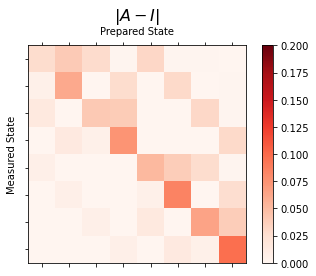

In [42]:
result.figure(0)

In [43]:
for m in mitigator._mitigation_mats:
    print(m)
    print()

[[ 1.00614125 -0.0419652 ]
 [-0.00614125  1.0419652 ]]

[[ 1.01530612 -0.02959184]
 [-0.01530612  1.02959184]]

[[ 1.0071066  -0.03248731]
 [-0.0071066   1.03248731]]



In [49]:
# On real example 
qc = QuantumCircuit(num_qubits)
qc.h(0)
for i in range(1, num_qubits):
    qc.cx(i - 1, i)
qc.measure_all()

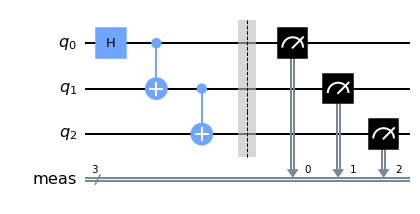

In [50]:
qc.draw()

In [46]:
counts = backend.run(qc,shots=SHOTS, seed_simulator=42, 
                     method = "density_matrix").result().get_counts()
unmitigated_probs = {label: count / SHOTS for label, count in counts.items()}

In [47]:
mitigated_quasi_probs = mitigator.quasi_probabilities(counts)
mitigated_stddev = mitigated_quasi_probs._stddev_upper_bound
mitigated_probs = (mitigated_quasi_probs.nearest_probability_distribution().binary_probabilities())

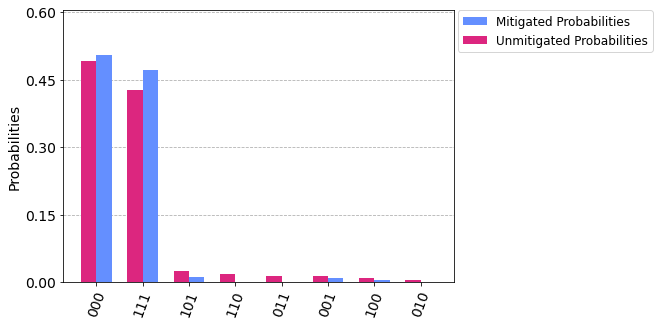

In [48]:
legend = ['Mitigated Probabilities', 'Unmitigated Probabilities']
plot_histogram([mitigated_probs, unmitigated_probs], legend=legend, sort="value_desc", bar_labels=False)